## python BLDC FOC controll simulation

for testing and showing main idea we show easy readable python FOC implemetnation

<Figure size 640x480 with 0 Axes>

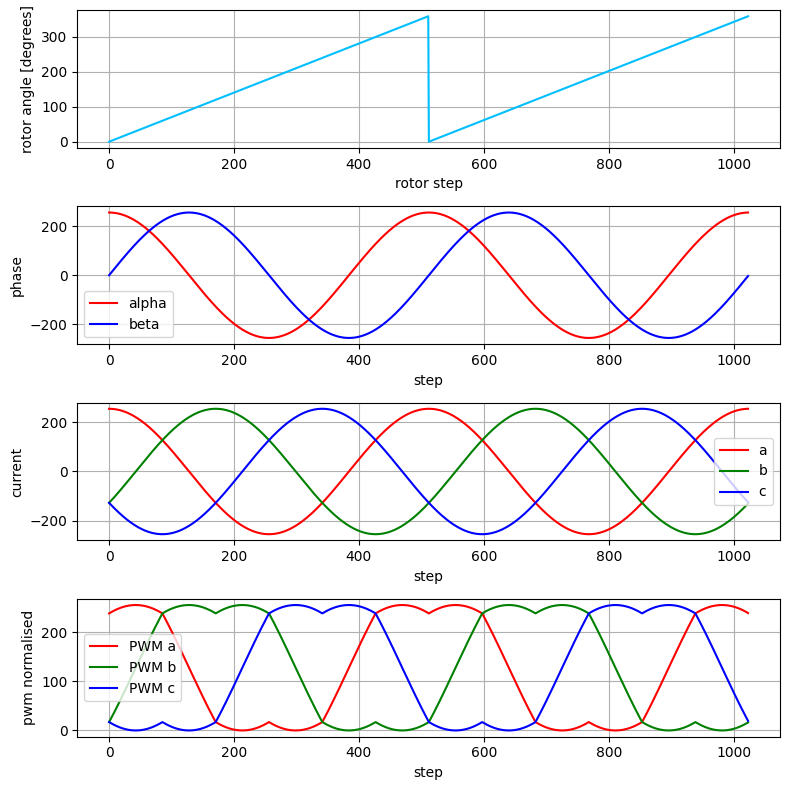

In [11]:
import numpy
import matplotlib.pyplot as plt

def set_torque(torque, phase):
    q = torque*numpy.cos(phase)
    d = torque*numpy.sin(phase)

    return d, q


def set_phases(d, q, theta, control_max = 1):
    #inverse Park transform
    alpha = d*numpy.cos(theta) - q*numpy.sin(theta)
    beta  = d*numpy.sin(theta) + q*numpy.cos(theta)
 
    #inverse Clarke transform
    a = alpha 
    b = -(alpha/2) + beta*numpy.sqrt(3)/2.0
    c = -(alpha/2) - beta*numpy.sqrt(3)/2.0

    # transform into space-vector modulation, to achieve full voltage range
    min_val = min([a, b, c])
    max_val = max([a, b, c])

    com_val = (min_val + max_val)/2.0

    # normalise waveform into 0..control_max range
    a_norm = ( (a - com_val)/numpy.sqrt(3) + control_max/2 )
    b_norm = ( (b - com_val)/numpy.sqrt(3) + control_max/2 )
    c_norm = ( (c - com_val)/numpy.sqrt(3) + control_max/2 )

    return alpha, beta, a, b, c, a_norm, b_norm, c_norm




if __name__ == "__main__":

    #max PWM amplitude
    control_max = 255.0

    #current PEM value
    torque      = 255

    phase       = 90*numpy.pi/180.0
    
    
    steps = 1024

    theta_res  = []
    
    alpha_res = []
    beta_res  = []

    a_res = []
    b_res = []
    c_res = []

    a_norm_res = []
    b_norm_res = []
    c_norm_res = []

    for n in range(steps):
        theta = (((2*n)%steps)/steps)*2.0*numpy.pi
        
        d, q = set_torque(torque, phase)

        alpha, beta, a, b, c, a_norm, b_norm, c_norm = set_phases(d, q, theta, control_max)

        theta_res.append(theta*180.0/numpy.pi)

        alpha_res.append(alpha)
        beta_res.append(beta)

        a_res.append(a)
        b_res.append(b)
        c_res.append(c)

        a_norm_res.append(a_norm)
        b_norm_res.append(b_norm)
        c_norm_res.append(c_norm)

    plt.clf()
    fig, axs = plt.subplots(4, 1, figsize=(8, 8))


    axs[0].plot(theta_res, label="theta", color="deepskyblue")
    axs[0].set_xlabel("rotor step")
    axs[0].set_ylabel("rotor angle [degrees]")
    axs[0].grid()

    axs[1].plot(alpha_res, label="alpha", color="red")
    axs[1].plot(beta_res, label="beta", color="blue")
    axs[1].set_xlabel("step")
    axs[1].set_ylabel("phase")
    axs[1].legend()
    axs[1].grid()


    axs[2].plot(a_res, label="a", color="red")
    axs[2].plot(b_res, label="b", color="green")
    axs[2].plot(c_res, label="c", color="blue")
    axs[2].set_xlabel("step")
    axs[2].set_ylabel("current")
    axs[2].legend()
    axs[2].grid()


    axs[3].plot(a_norm_res, label="PWM a", color="red")
    axs[3].plot(b_norm_res, label="PWM b", color="green")
    axs[3].plot(c_norm_res, label="PWM c", color="blue")
    axs[3].set_xlabel("step")
    axs[3].set_ylabel("pwm normalised")
    axs[3].legend()
    axs[3].grid()
        
    plt.tight_layout()
    plt.show()
    #plt.savefig("output.png", dpi = 300)

## c++ integer arithemtics BLDC FOC controll implementation

for effective run on MCU (typically with 500Hz..4000Hz) we need transform code into C++ using only integer arithmetics

### sine cosine table
    - sine and cosine are precomputed in table, ranging from <0, 1024> (360degrees equals to 1024)
        - SINE_TABLE_SIZE = 1024
    - values ranging from -512 to 512
        - SINE_TABLE_MAX = 1024
c++ implementation is in [gonio.h](./cpp/gonio.h)


### motor controll constants

    - motor torque with 10bit resolution, MOTOR_CONTROL_MAX = 1024
    - PWM period is set to 20kHz, when timer running on 24MHz the period will be : 
        - #define PWM_FREQUENCY           ((uint32_t)20000)
        - #define PWM_PERIOD              ((uint32_t)24000000/PWM_FREQUENCY - 1)
    - motor have 14 electric poles, MOTOR_POLES = 14
    - phase for full torque is +-90degrees, which equals with +SINE_TABLE_SIZE/4 or -SINE_TABLE_SIZE/4


### another constant values and helping functions

```cpp
#define SQRT3       ((int32_t)1773)      // sqrt(3)     = 1773/1024
#define SQRT3INV    ((int32_t)591)       // 1/sqrt(3)   = 591/1024

#define max2(x,y) (((x) >= (y)) ? (x) : (y))
#define min2(x,y) (((x) <= (y)) ? (x) : (y))

#define max3(x, y, z) (max2(max2(x, y), z))
#define min3(x, y, z) (min2(min2(x, y), z))
```

### main code

this fucntion is called as fast as possible, filled with required torque, motor rotation way (phase), and rotor angle reading

- torque: 0..MOTOR_CONTROL_MAX
- phase : +SINE_TABLE_SIZE/4 or -SINE_TABLE_SIZE/4, controlling motor way
- rotor_angle : readed from encoder, 0..4096

```cpp
/*
    torque      : required motor torque
    phase       : required phase angle, 90degrees for maximum torque
    rotor_angle : readed from encoder
*/
void Motor::set_phases(int32_t torque, uint32_t phase, uint32_t rotor_angle)
{
    int32_t q = (torque*cos_tab(phase))/SINE_TABLE_MAX;
    int32_t d = (torque*sin_tab(phase))/SINE_TABLE_MAX;

    // inverse Park transform
    int32_t theta = (rotor_angle*MOTOR_POLES)/(2*4)
    int32_t alpha = (d*cos_tab(theta) - q*sin_tab(theta))/SINE_TABLE_MAX;
    int32_t beta  = (d*sin_tab(theta) + q*cos_tab(theta))/SINE_TABLE_MAX;

    // inverse Clarke transform
    int32_t a = alpha;
    int32_t b = -(alpha/2) + (SQRT3*beta)/(2*1024);
    int32_t c = -(alpha/2) - (SQRT3*beta)/(2*1024);

    
    // transform into space-vector modulation, to achieve full voltage range
    int32_t min_val = min3(a, b, c);
    int32_t max_val = max3(a, b, c); 

    int32_t com_val = (min_val + max_val)/2;  

    // normalise waveform into 0..control_max range
    int32_t a_pwm = ((a - com_val)*SQRT3INV)/1024 + MOTOR_CONTROL_MAX/2;
    int32_t b_pwm = ((b - com_val)*SQRT3INV)/1024 + MOTOR_CONTROL_MAX/2;
    int32_t c_pwm = ((c - com_val)*SQRT3INV)/1024 + MOTOR_CONTROL_MAX/2;
    
     
    a_pwm = clamp((a_pwm*PWM_PERIOD)/MOTOR_CONTROL_MAX, 0, PWM_PERIOD);
    b_pwm = clamp((b_pwm*PWM_PERIOD)/MOTOR_CONTROL_MAX, 0, PWM_PERIOD);
    c_pwm = clamp((c_pwm*PWM_PERIOD)/MOTOR_CONTROL_MAX, 0, PWM_PERIOD);

    //custom PWM output signals for motor driver
    set_pwm(a_pwm, b_pwm, c_pwm);
}
```